In [1]:
import pandas as pd
import numpy as np
import time
import plotly.express as px
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

Like with Stage 2, I'm going to need state data on covid new cases. I'm simply re-running my code from Stage 2, so I won't be included any new markdown comments. 

In [2]:
data=pd.read_csv("../../../../data/stage_1/superdataset.csv")

#Removing statewide unallocated
data = data[data.County_Name != 'statewide unallocated']

#Ensuring data is datetime
data['Date']=pd.to_datetime(data['Date'])
data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
748,1001,autauga county,AL,2020-01-22,0,0,55869
749,1001,autauga county,AL,2020-01-23,0,0,55869
750,1001,autauga county,AL,2020-01-24,0,0,55869
751,1001,autauga county,AL,2020-01-25,0,0,55869
752,1001,autauga county,AL,2020-01-26,0,0,55869
...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927
2346472,56045,weston county,WY,2022-02-04,1496,17,6927
2346473,56045,weston county,WY,2022-02-05,1496,17,6927
2346474,56045,weston county,WY,2022-02-06,1496,17,6927


In [3]:
indiana_covid = data[data["State"].isin(["IN"])].reset_index(drop=True)
indiana_covid_agg=indiana_covid.drop(columns=['countyFIPS','County_Name','State','population'])
indiana_covid_agg=indiana_covid_agg.groupby('Date').agg('sum')
indiana_covid_agg

,Confirmed,Deaths
Date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2022-02-03,1646804,21666
2022-02-04,1651124,21712
2022-02-05,1651124,21712


In [4]:
#Summing unique population values in Indiana
indiana_pop=indiana_covid.population.drop_duplicates().sum()
indiana_pop

6732219

In [5]:
#New Cases
indiana_covid_agg['New_Confirmed']=indiana_covid_agg['Confirmed'].diff()

#New Deaths
indiana_covid_agg['New_Deaths']=indiana_covid_agg['Deaths'].diff()

#Removing Unneeded columns
indiana_covid_agg=indiana_covid_agg.drop(columns=["Confirmed",'Deaths'])
indiana_covid_agg

,New_Confirmed,New_Deaths
Date,,
2020-01-22,NaN,NaN
2020-01-23,0.0,0.0
2020-01-24,0.0,0.0
2020-01-25,0.0,0.0
2020-01-26,0.0,0.0
...,...,...
2022-02-03,6626.0,68.0
2022-02-04,4320.0,46.0
2022-02-05,0.0,0.0


In [6]:
indiana_covid_agg = indiana_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
indiana_covid_agg

,New_Confirmed,New_Deaths
Date,,
2020-01-26,0.0,0.0
2020-01-27,0.0,0.0
2020-01-28,0.0,0.0
2020-01-29,0.0,0.0
2020-01-30,0.0,0.0
...,...,...
2022-02-03,6626.0,68.0
2022-02-04,4320.0,46.0
2022-02-05,0.0,0.0


In [7]:
indiana_weekly_avg = indiana_covid_agg
indiana_weekly_avg.reset_index(inplace=True)

#Using resample to aggregate daily to weekly
indiana_weekly_avg = indiana_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
indiana_weekly_avg.New_Confirmed = indiana_weekly_avg.New_Confirmed.round()
indiana_weekly_avg.New_Deaths = indiana_weekly_avg.New_Deaths.round()
indiana_weekly_avg

,New_Confirmed,New_Deaths
Date,,
2020-01-26,0.0,0.0
2020-02-02,0.0,0.0
2020-02-09,0.0,0.0
2020-02-16,0.0,0.0
2020-02-23,0.0,0.0
...,...,...
2022-01-09,13791.0,87.0
2022-01-16,14098.0,75.0
2022-01-23,11369.0,79.0


In [8]:
indiana_weekly_avg.describe()

,New_Confirmed,New_Deaths
count,107.000000,107.000000
mean,2228.056075,29.495327
std,2746.507531,32.089019
min,0.000000,0.000000
25%,518.500000,10.000000
50%,1001.000000,20.000000
75%,2878.000000,42.000000
max,14098.000000,255.000000


In [9]:
indiana_weekly_avg['New_Confirmed_per_100000'] = indiana_weekly_avg.New_Confirmed/indiana_pop *100000
indiana_weekly_avg['New_Deaths_per_100000'] = indiana_weekly_avg.New_Deaths/indiana_pop *100000
x=len(indiana_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if indiana_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        indiana_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if indiana_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        indiana_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
indiana_weekly_avg['lognormal_Confirmed'] = np.log10(indiana_weekly_avg.New_Confirmed_per_100000)
indiana_weekly_avg['lognormal_Deaths'] = np.log10(indiana_weekly_avg.New_Deaths_per_100000)
indiana_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,13791.0,87.0,204.850733,1.292293,2.311438,0.111361
2022-01-16,14098.0,75.0,209.410894,1.114046,2.320999,0.046903
2022-01-23,11369.0,79.0,168.874483,1.173462,2.227564,0.069469


Ohio:

In [10]:
ohio_covid = data[data["State"].isin(["OH"])].reset_index(drop=True)
ohio_pop=ohio_covid.population.drop_duplicates().sum()
ohio_covid_agg=ohio_covid.drop(columns=['countyFIPS','County_Name','State','population'])
ohio_covid_agg=ohio_covid_agg.groupby('Date').agg('sum')

#New Cases
ohio_covid_agg['New_Confirmed']=ohio_covid_agg['Confirmed'].diff()

#New Deaths
ohio_covid_agg['New_Deaths']=ohio_covid_agg['Deaths'].diff()

#Removing Unneeded columns
ohio_covid_agg=ohio_covid_agg.drop(columns=["Confirmed",'Deaths'])
ohio_covid_agg = ohio_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
ohio_weekly_avg = ohio_covid_agg
ohio_weekly_avg.reset_index(inplace=True)

#Resampling
ohio_weekly_avg = ohio_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
ohio_weekly_avg.New_Confirmed = ohio_weekly_avg.New_Confirmed.round()
ohio_weekly_avg.New_Deaths = ohio_weekly_avg.New_Deaths.round()
ohio_weekly_avg['New_Confirmed_per_100000'] = ohio_weekly_avg.New_Confirmed/ohio_pop *100000
ohio_weekly_avg['New_Deaths_per_100000'] = ohio_weekly_avg.New_Deaths/ohio_pop *100000
x=len(ohio_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if ohio_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        ohio_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if ohio_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        ohio_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
ohio_weekly_avg['lognormal_Confirmed'] = np.log10(ohio_weekly_avg.New_Confirmed_per_100000)
ohio_weekly_avg['lognormal_Deaths'] = np.log10(ohio_weekly_avg.New_Deaths_per_100000)
ohio_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,22266.0,121.0,190.485153,1.035152,2.279861,0.015004
2022-01-16,24696.0,152.0,211.273751,1.300357,2.324846,0.114063
2022-01-23,11692.0,155.0,100.024809,1.326022,2.000108,0.122551


Illinois:

In [11]:
illinois_covid = data[data["State"].isin(["IL"])].reset_index(drop=True)
illinois_pop=illinois_covid.population.drop_duplicates().sum()
illinois_covid_agg=illinois_covid.drop(columns=['countyFIPS','County_Name','State','population'])
illinois_covid_agg=illinois_covid_agg.groupby('Date').agg('sum')

#New Cases
illinois_covid_agg['New_Confirmed']=illinois_covid_agg['Confirmed'].diff()

#New Deaths
illinois_covid_agg['New_Deaths']=illinois_covid_agg['Deaths'].diff()

#Removing Unneeded columns
illinois_covid_agg=illinois_covid_agg.drop(columns=["Confirmed",'Deaths'])
illinois_covid_agg = illinois_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
illinois_weekly_avg = illinois_covid_agg
illinois_weekly_avg.reset_index(inplace=True)

#Resampling
illinois_weekly_avg = illinois_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
illinois_weekly_avg.New_Confirmed = illinois_weekly_avg.New_Confirmed.round()
illinois_weekly_avg.New_Deaths = illinois_weekly_avg.New_Deaths.round()
illinois_weekly_avg['New_Confirmed_per_100000'] = illinois_weekly_avg.New_Confirmed/illinois_pop *100000
illinois_weekly_avg['New_Deaths_per_100000'] = illinois_weekly_avg.New_Deaths/illinois_pop *100000
x=len(illinois_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if illinois_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        illinois_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if illinois_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        illinois_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
illinois_weekly_avg['lognormal_Confirmed'] = np.log10(illinois_weekly_avg.New_Confirmed_per_100000)
illinois_weekly_avg['lognormal_Deaths'] = np.log10(illinois_weekly_avg.New_Deaths_per_100000)
illinois_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,29973.0,107.0,236.532697,0.844393,2.373891,-0.073455
2022-01-16,27590.0,110.0,217.727192,0.868068,2.337913,-0.061446
2022-01-23,13236.0,120.0,104.452233,0.946983,2.018918,-0.023658


Michigan:

In [12]:
michigan_covid = data[data["State"].isin(["MI"])].reset_index(drop=True)
michigan_pop=michigan_covid.population.drop_duplicates().sum()
michigan_covid_agg=michigan_covid.drop(columns=['countyFIPS','County_Name','State','population'])
michigan_covid_agg=michigan_covid_agg.groupby('Date').agg('sum')

#New Cases
michigan_covid_agg['New_Confirmed']=michigan_covid_agg['Confirmed'].diff()

#New Deaths
michigan_covid_agg['New_Deaths']=michigan_covid_agg['Deaths'].diff()

#Removing Unneeded columns
michigan_covid_agg=michigan_covid_agg.drop(columns=["Confirmed",'Deaths'])
michigan_covid_agg = michigan_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
michigan_weekly_avg = michigan_covid_agg
michigan_weekly_avg.reset_index(inplace=True)

#Resampling
michigan_weekly_avg = michigan_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
michigan_weekly_avg.New_Confirmed = michigan_weekly_avg.New_Confirmed.round()
michigan_weekly_avg.New_Deaths = michigan_weekly_avg.New_Deaths.round()
michigan_weekly_avg['New_Confirmed_per_100000'] = michigan_weekly_avg.New_Confirmed/michigan_pop *100000
michigan_weekly_avg['New_Deaths_per_100000'] = michigan_weekly_avg.New_Deaths/michigan_pop *100000
x=len(michigan_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if michigan_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        michigan_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if michigan_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        michigan_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
michigan_weekly_avg['lognormal_Confirmed'] = np.log10(michigan_weekly_avg.New_Confirmed_per_100000)
michigan_weekly_avg['lognormal_Deaths'] = np.log10(michigan_weekly_avg.New_Deaths_per_100000)
michigan_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,18099.0,108.0,181.228188,1.081421,2.258226,0.033995
2022-01-16,19670.0,113.0,196.958863,1.131487,2.294376,0.053650
2022-01-23,15532.0,99.0,155.524406,0.991303,2.191799,-0.003794


Kentucky:

In [13]:
kentucky_covid = data[data["State"].isin(["KY"])].reset_index(drop=True)
kentucky_pop=kentucky_covid.population.drop_duplicates().sum()
kentucky_covid_agg=kentucky_covid.drop(columns=['countyFIPS','County_Name','State','population'])
kentucky_covid_agg=kentucky_covid_agg.groupby('Date').agg('sum')

#New Cases
kentucky_covid_agg['New_Confirmed']=kentucky_covid_agg['Confirmed'].diff()

#New Deaths
kentucky_covid_agg['New_Deaths']=kentucky_covid_agg['Deaths'].diff()

#Removing Unneeded columns
kentucky_covid_agg=kentucky_covid_agg.drop(columns=["Confirmed",'Deaths'])
kentucky_covid_agg = kentucky_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
kentucky_weekly_avg = kentucky_covid_agg
kentucky_weekly_avg.reset_index(inplace=True)

#Resampling
kentucky_weekly_avg = kentucky_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
kentucky_weekly_avg.New_Confirmed = kentucky_weekly_avg.New_Confirmed.round()
kentucky_weekly_avg.New_Deaths = kentucky_weekly_avg.New_Deaths.round()
kentucky_weekly_avg['New_Confirmed_per_100000'] = kentucky_weekly_avg.New_Confirmed/kentucky_pop *100000
kentucky_weekly_avg['New_Deaths_per_100000'] = kentucky_weekly_avg.New_Deaths/kentucky_pop *100000
x=len(kentucky_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if kentucky_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        kentucky_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if kentucky_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        kentucky_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
kentucky_weekly_avg['lognormal_Confirmed'] = np.log10(kentucky_weekly_avg.New_Confirmed_per_100000)
kentucky_weekly_avg['lognormal_Deaths'] = np.log10(kentucky_weekly_avg.New_Deaths_per_100000)
kentucky_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,8495.0,23.0,190.143728,0.514809,2.279082,-0.288354
2022-01-16,11563.0,24.0,258.814824,0.537192,2.412989,-0.269870
2022-01-23,12086.0,29.0,270.521142,0.649107,2.432201,-0.187683


Wisconsin:

In [14]:
wisconsin_covid = data[data["State"].isin(["WI"])].reset_index(drop=True)
wisconsin_pop=wisconsin_covid.population.drop_duplicates().sum()
wisconsin_covid_agg=wisconsin_covid.drop(columns=['countyFIPS','County_Name','State','population'])
wisconsin_covid_agg=wisconsin_covid_agg.groupby('Date').agg('sum')

#New Cases
wisconsin_covid_agg['New_Confirmed']=wisconsin_covid_agg['Confirmed'].diff()

#New Deaths
wisconsin_covid_agg['New_Deaths']=wisconsin_covid_agg['Deaths'].diff()

#Removing Unneeded columns
wisconsin_covid_agg=wisconsin_covid_agg.drop(columns=["Confirmed",'Deaths'])
wisconsin_covid_agg = wisconsin_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
wisconsin_weekly_avg = wisconsin_covid_agg
wisconsin_weekly_avg.reset_index(inplace=True)

#Resampling
wisconsin_weekly_avg = wisconsin_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
wisconsin_weekly_avg.New_Confirmed = wisconsin_weekly_avg.New_Confirmed.round()
wisconsin_weekly_avg.New_Deaths = wisconsin_weekly_avg.New_Deaths.round()
wisconsin_weekly_avg['New_Confirmed_per_100000'] = wisconsin_weekly_avg.New_Confirmed/wisconsin_pop *100000
wisconsin_weekly_avg['New_Deaths_per_100000'] = wisconsin_weekly_avg.New_Deaths/wisconsin_pop *100000
x=len(wisconsin_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if wisconsin_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        wisconsin_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if wisconsin_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        wisconsin_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
wisconsin_weekly_avg['lognormal_Confirmed'] = np.log10(wisconsin_weekly_avg.New_Confirmed_per_100000)
wisconsin_weekly_avg['lognormal_Deaths'] = np.log10(wisconsin_weekly_avg.New_Deaths_per_100000)
wisconsin_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,16336.0,34.0,280.569947,0.583948,2.448041,-0.233626
2022-01-16,19265.0,54.0,330.875369,0.927447,2.519664,-0.032711
2022-01-23,7461.0,50.0,128.142286,0.858747,2.107692,-0.066135


In [15]:
indiana_confirmed=indiana_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
indiana_confirmed[["State"]]="Indiana"
indiana_confirmed

ohio_confirmed=ohio_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
ohio_confirmed[["State"]]="Ohio"
ohio_confirmed

michigan_confirmed=michigan_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
michigan_confirmed[["State"]]="Michigan"
michigan_confirmed

illinois_confirmed=illinois_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
illinois_confirmed[["State"]]="Illinois"
illinois_confirmed

kentucky_confirmed=kentucky_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
kentucky_confirmed[["State"]]="Kentucky"
kentucky_confirmed

wisconsin_confirmed=wisconsin_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
wisconsin_confirmed[["State"]]="Wisconsin"
wisconsin_confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
Date,,,
2020-01-26,0.100000,0.100000,Wisconsin
2020-02-02,0.100000,0.100000,Wisconsin
2020-02-09,0.100000,0.100000,Wisconsin
2020-02-16,0.100000,0.100000,Wisconsin
2020-02-23,0.100000,0.100000,Wisconsin
...,...,...,...
2022-01-09,280.569947,0.583948,Wisconsin
2022-01-16,330.875369,0.927447,Wisconsin
2022-01-23,128.142286,0.858747,Wisconsin


In [16]:
confirmed=indiana_confirmed.merge(ohio_confirmed,how='outer')
confirmed=confirmed.merge(michigan_confirmed,how='outer')
confirmed=confirmed.merge(illinois_confirmed,how='outer')
confirmed=confirmed.merge(kentucky_confirmed,how='outer')
confirmed=confirmed.merge(wisconsin_confirmed,how='outer')
confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
0,0.100000,0.100000,Indiana
1,0.100000,0.100000,Indiana
2,0.100000,0.100000,Indiana
3,0.100000,0.100000,Indiana
4,0.100000,0.100000,Indiana
...,...,...,...
637,280.569947,0.583948,Wisconsin
638,330.875369,0.927447,Wisconsin
639,128.142286,0.858747,Wisconsin
640,71.808457,0.549598,Wisconsin


In [17]:
Dates=indiana_confirmed.index.values
Dates1=np.append(Dates,Dates)
Dates2=np.append(Dates1,Dates)
Dates3=np.append(Dates2,Dates)
Dates4=np.append(Dates3,Dates)
Dates5=np.append(Dates4,Dates)
Dates
confirmed.index=Dates5
confirmed.New_Confirmed_per_100000=confirmed.New_Confirmed_per_100000.round()
confirmed.New_Deaths_per_100000=confirmed.New_Deaths_per_100000.round()
confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
2020-01-26,0.0,0.0,Indiana
2020-02-02,0.0,0.0,Indiana
2020-02-09,0.0,0.0,Indiana
2020-02-16,0.0,0.0,Indiana
2020-02-23,0.0,0.0,Indiana
...,...,...,...
2022-01-09,281.0,1.0,Wisconsin
2022-01-16,331.0,1.0,Wisconsin
2022-01-23,128.0,1.0,Wisconsin
2022-01-30,72.0,1.0,Wisconsin


Now we have our data set up again for Stage 3. For the first part, we will once again use Indiana as the state of choice. Let's graph the new weekly cases for Indiana in a histogram.

<AxesSubplot:>

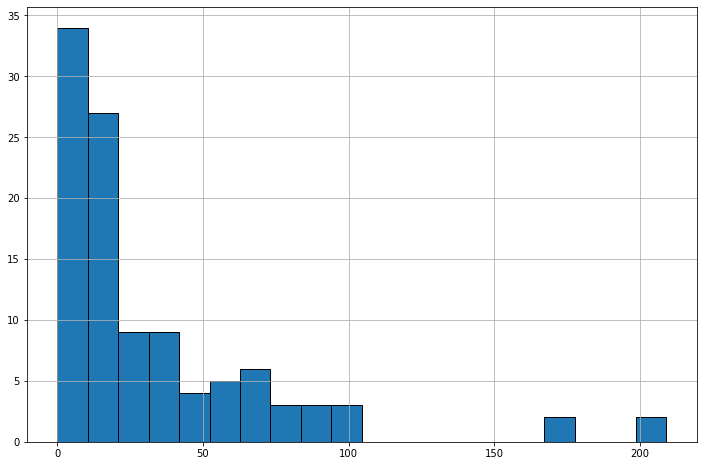

In [18]:
indiana_confirmed = confirmed[confirmed["State"].isin(["Indiana"])]
indiana_confirmed.New_Confirmed_per_100000.hist(bins=20, ec='black', figsize=(12,8))

Hmm, a histogram doesn't seem to be that useful here, as our new cases are a continuous variable instead of discrete. Let's plot a density plot instead. We are maxing the x axis at 350 because the max value for cases in all states is 330. As such, as we look at multiple states, the line likely will stop prematurely.

<AxesSubplot:ylabel='Density'>

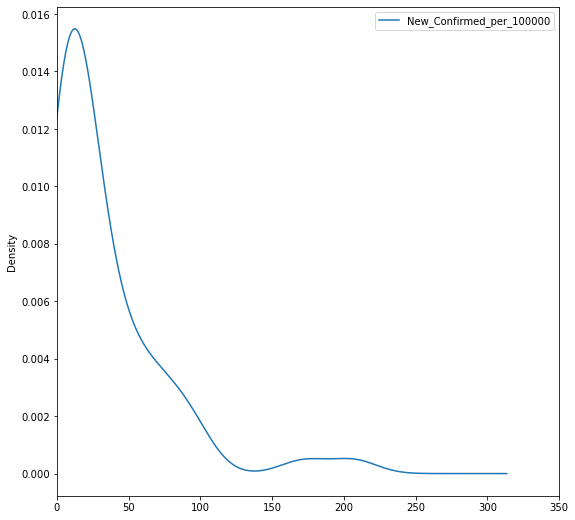

In [19]:
pd.DataFrame(indiana_confirmed.New_Confirmed_per_100000).plot(kind="density",
                               figsize=(9,9),
                               xlim=(0,350))

Based on the density plot above, Indiana appears to follow a gamma distribution for its new weekly COVID cases. What are its statistics?

In [20]:
indiana_confirmed.New_Confirmed_per_100000.mean()

33.09345794392523

The mean looks to be just over 33.

In [21]:
indiana_confirmed.New_Confirmed_per_100000.var()

1663.1043907600067

Variance is nearly 1,664.

In [22]:
from scipy.stats import skew
skew(indiana_confirmed.New_Confirmed_per_100000)

2.359975746241423

Our skewness is quite high, but that's not surprising considering what we saw from the density plot above.

In [23]:
from scipy.stats import kurtosis
kurtosis(indiana_confirmed.New_Confirmed_per_100000)

6.336053135573369

Like with skewness, kurtosis is high, again not surprising considering the density plot. So how do other states look? 

<AxesSubplot:ylabel='Density'>

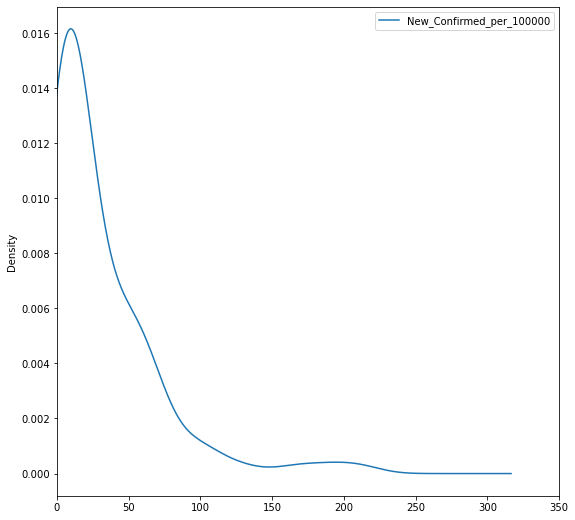

In [24]:
pd.DataFrame(confirmed[confirmed["State"].isin(["Ohio"])]).plot(kind="density",
                             y="New_Confirmed_per_100000",
                               figsize=(9,9),
                               xlim=(0,350))
                               

<AxesSubplot:ylabel='Density'>

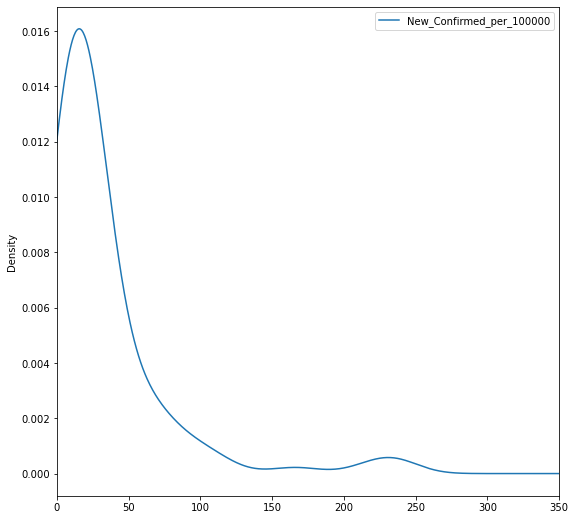

In [25]:
pd.DataFrame(confirmed[confirmed["State"].isin(["Illinois"])]).plot(kind="density",
                             y="New_Confirmed_per_100000",
                               figsize=(9,9),
                               xlim=(0,350))
                               

<AxesSubplot:ylabel='Density'>

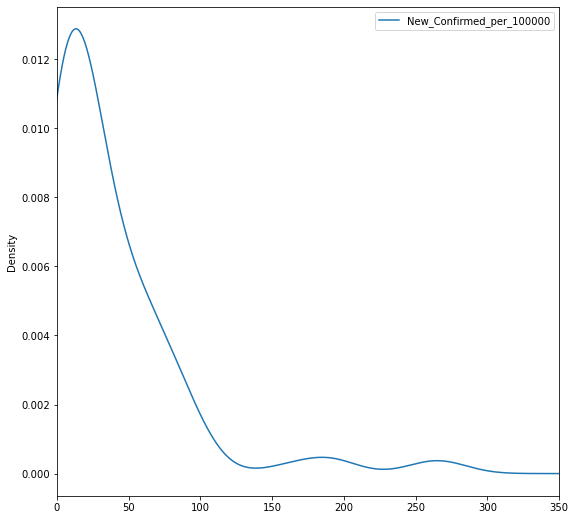

In [26]:
pd.DataFrame(confirmed[confirmed["State"].isin(["Kentucky"])]).plot(kind="density",
                             y="New_Confirmed_per_100000",
                               figsize=(9,9),
                               xlim=(0,350))
                               

<AxesSubplot:ylabel='Density'>

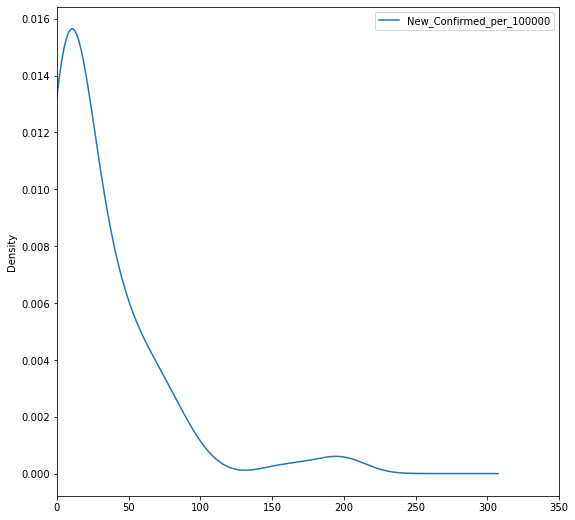

In [27]:
pd.DataFrame(confirmed[confirmed["State"].isin(["Michigan"])]).plot(kind="density",
                             y="New_Confirmed_per_100000",
                               figsize=(9,9),
                               xlim=(0,350))
                               

<AxesSubplot:ylabel='Density'>

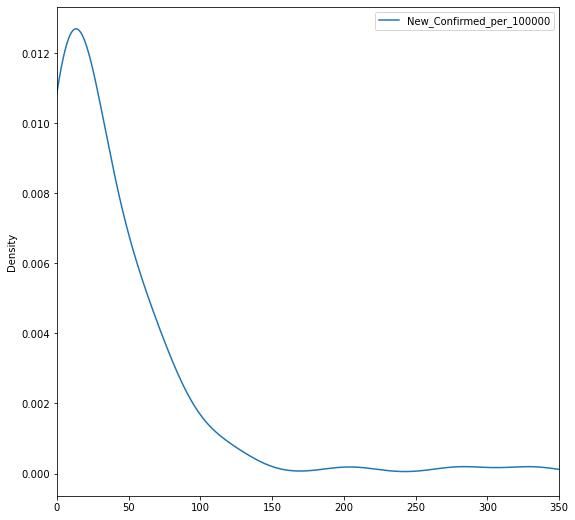

In [28]:
pd.DataFrame(confirmed[confirmed["State"].isin(["Wisconsin"])]).plot(kind="density",
                             y="New_Confirmed_per_100000",
                               figsize=(9,9),
                               xlim=(0,350))
                               

As we can see, the distributions are nearly identical for every state. This would indicate that each of the states have similar patterns in regards to weekly average covid cases. This makes sense, since all of these states are geographically close to each other, so their COVID case patterns would be influenced by each other. We now are moving on to poisson distributions for each state.

We'll use the mean value for indiana cases as our parameter for generating our poisson distribution. In this example we chose to have a sample size of 100,000, since that is what our cases are multiplied by.

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

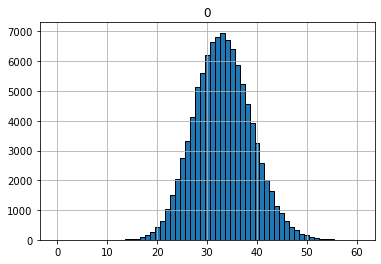

In [29]:
indiana_cases_poisson=stats.poisson.rvs(size=100000, mu=indiana_confirmed.New_Confirmed_per_100000.mean())
pd.DataFrame(indiana_cases_poisson).hist(range=(-0.5,max(indiana_cases_poisson)+0.5)
                                    , bins=max(indiana_cases_poisson)+1, ec='black')

Unlike what we saw with our density plots, the poisson plot is much more symmetrical. This is in part due to large sample size, and also due to the nature of poisson distributions. They model the probability of seeing a certain number of successes within a time interval (in this case, one week). It's single parameter is a mean value, which as mentioned before is the mean number of cases per week. So, when sampling, it will be sampling around the mean, so values closest to the mean will be higher. If the average number of cases (successes) is around 33, then the distribution will peak around 33. 

In [30]:
indiana_cases_poisson.max()

60

This is the max value in our poisson distribution. I wonder what percentage of successes was at this max?

In [31]:
stats.poisson.pmf(k=indiana_cases_poisson.max(),mu=indiana_confirmed.New_Confirmed_per_100000.mean())

7.799161667294146e-06

Apparently, an extremely low percentage, in the hundred-thousandths of a percent. What about the min?

In [32]:
indiana_cases_poisson.min()

11

In [33]:
stats.poisson.pmf(k=indiana_cases_poisson.min(),mu=indiana_confirmed.New_Confirmed_per_100000.mean())

5.54244956240871e-06

Basically the same thing, it appears. Let's try a couple more numbers. How about 20?

In [34]:
stats.poisson.pmf(k=20,mu=indiana_confirmed.New_Confirmed_per_100000.mean())

0.004329245283082334

Even when we bump up to 20, we still only have less than half a percent chance of exactly 20 cases per 100,000 per week. How about about 33, close to the mean?

In [35]:
stats.poisson.pmf(k=33,mu=indiana_confirmed.New_Confirmed_per_100000.mean())

0.06926264307789927

Here we're finally seeing usable percentages. There is essentially a 7% chance of exactly 33 cases per 100,000 in a week. This seems likely, as even though the mean is near 33, there are a lot of numbers that can be selected, so the odds of exactly 33 will still not be particularly high. This percentage increases the lower the mean parameter is. Lastly, just for fun, let's look at 40. 

In [36]:
stats.poisson.pmf(k=40,mu=indiana_confirmed.New_Confirmed_per_100000.mean())

0.03204311457071284

Just over 3% for exactly 40 cases, to be expected considering its proximity to 33. How do the other states compare?

Michigan:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

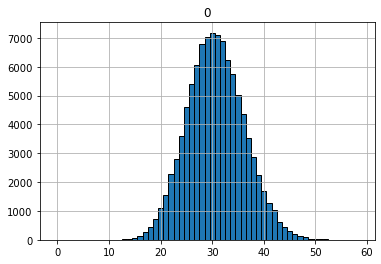

In [37]:
michigan_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Michigan"])].New_Confirmed_per_100000.mean())
pd.DataFrame(michigan_cases_poisson).hist(range=(-0.5,max(michigan_cases_poisson)+0.5)
                                    , bins=max(michigan_cases_poisson)+1, ec='black')

Ohio:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

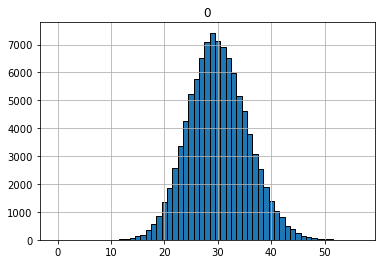

In [38]:
ohio_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Ohio"])].New_Confirmed_per_100000.mean())
pd.DataFrame(ohio_cases_poisson).hist(range=(-0.5,max(ohio_cases_poisson)+0.5)
                                    , bins=max(ohio_cases_poisson)+1, ec='black')

Illinois:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

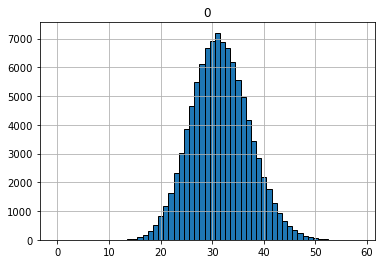

In [39]:
illinois_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Illinois"])].New_Confirmed_per_100000.mean())
pd.DataFrame(illinois_cases_poisson).hist(range=(-0.5,max(illinois_cases_poisson)+0.5)
                                    , bins=max(illinois_cases_poisson)+1, ec='black')

Kentucky:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

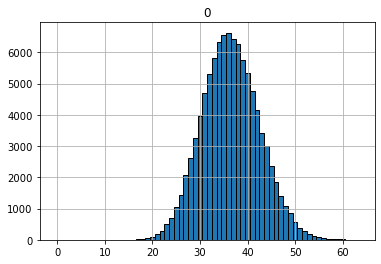

In [40]:
kentucky_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Kentucky"])].New_Confirmed_per_100000.mean())
pd.DataFrame(kentucky_cases_poisson).hist(range=(-0.5,max(kentucky_cases_poisson)+0.5)
                                    , bins=max(kentucky_cases_poisson)+1, ec='black')

Wisconsin:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

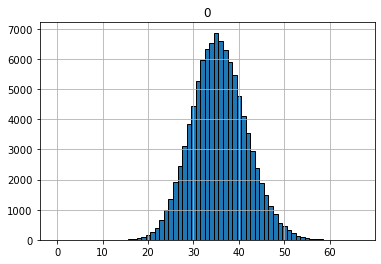

In [41]:
wisconsin_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Wisconsin"])].New_Confirmed_per_100000.mean())
pd.DataFrame(wisconsin_cases_poisson).hist(range=(-0.5,max(wisconsin_cases_poisson)+0.5)
                                    , bins=max(wisconsin_cases_poisson)+1, ec='black')

Not surprisingly, the other 5 states have distributions near identical to Indiana. The main difference comes from the mean point of the poisson distribution. Illinois is the most similar to Indiana, at around 32. Wisconsin looks to be at 33 as well, but numbers above it don't drop as quickly. Both Michigan and Ohio hover around 30. Interestingly, Kentucky has higher mean near 36 or 37. This data further confirms my previous statement that the 5 states closely mirror each other in Covid cases. How about deaths?

Indiana:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

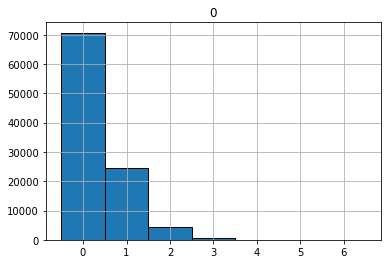

In [42]:
indiana_deaths_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Indiana"])].New_Deaths_per_100000.mean())
pd.DataFrame(indiana_deaths_poisson).hist(range=(-0.5,max(indiana_deaths_poisson)+0.5)
                                    , bins=max(indiana_deaths_poisson)+1, ec='black')

This is where my prior point about higher mean parameters for a poisson distribution make sense. Since very few people per 100,000 die per week, the mean is very low, so the data becomes skewed. 

In [43]:
stats.poisson.pmf(k=0,mu=confirmed[confirmed["State"].isin(["Indiana"])].New_Deaths_per_100000.mean())

0.707657971919534

This is a prime example. 70% chance that 0 people died per 100,000 per week. What about the other states?

Michigan

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

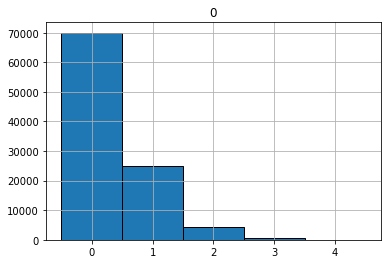

In [44]:
michigan_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Michigan"])].New_Deaths_per_100000.mean())
pd.DataFrame(michigan_cases_poisson).hist(range=(-0.5,max(michigan_cases_poisson)+0.5)
                                    , bins=max(michigan_cases_poisson)+1, ec='black')

Ohio:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

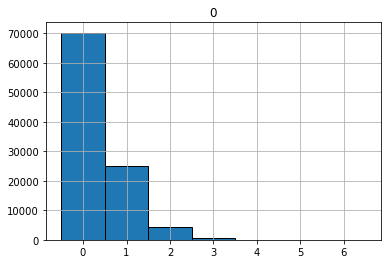

In [45]:
ohio_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Ohio"])].New_Deaths_per_100000.mean())
pd.DataFrame(ohio_cases_poisson).hist(range=(-0.5,max(ohio_cases_poisson)+0.5)
                                    , bins=max(ohio_cases_poisson)+1, ec='black')

Illinois:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

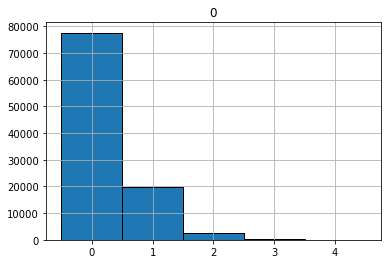

In [46]:
illinois_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Illinois"])].New_Deaths_per_100000.mean())
pd.DataFrame(illinois_cases_poisson).hist(range=(-0.5,max(illinois_cases_poisson)+0.5)
                                    , bins=max(illinois_cases_poisson)+1, ec='black')

Kentucky:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

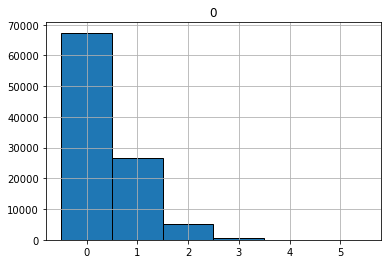

In [47]:
kentucky_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Kentucky"])].New_Deaths_per_100000.mean())
pd.DataFrame(kentucky_cases_poisson).hist(range=(-0.5,max(kentucky_cases_poisson)+0.5)
                                    , bins=max(kentucky_cases_poisson)+1, ec='black')

Wisconsin:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

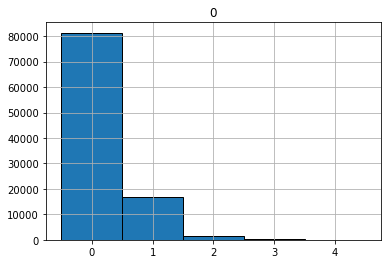

In [48]:
wisconsin_cases_poisson=stats.poisson.rvs(size=100000, mu=confirmed[confirmed["State"].isin(["Wisconsin"])].New_Deaths_per_100000.mean())
pd.DataFrame(wisconsin_cases_poisson).hist(range=(-0.5,max(wisconsin_cases_poisson)+0.5)
                                    , bins=max(wisconsin_cases_poisson)+1, ec='black')

They all follow the same trend, though interestingly Wisconsin is the only one to never generate 3 out of 100,000. 

We now need to pull in our Enrichment data, and aggregate up to state level for analyses. 

In [49]:
enrichment=pd.read_csv("../../../../data/stage_1/ACS_Economic_Social_Merged.csv")
enrichment.head()

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,No_Diploma,High_School,Associates,...,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level
0,1003,baldwin county,AL,1/22/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1
1,1003,baldwin county,AL,1/23/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1
2,1003,baldwin county,AL,1/24/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1
3,1003,baldwin county,AL,1/25/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1
4,1003,baldwin county,AL,1/26/2020,0,0,223234,12068,41884,16170,...,3189,7760,8552,13600,11589,10969,13141,4064,5393,10.1


Population will be needed for normalizing the data, but it is being parsed out here because we are using a different aggregate function than what the other columns will have. 

In [50]:
state_pop=enrichment[['County_Name','State','population']]
#Removing duplicates due to dates, since population doesn't change based on date
state_pop=state_pop.drop_duplicates(subset=['County_Name'])
state_pop=state_pop.groupby("State").agg("sum")
#Getting just the states we need
needed_pop=state_pop[state_pop.index.isin(['IN','IL','MI','WI','OH','KY'])]
needed_pop

,population
State,
IL,9509270
IN,3044333
KY,890301
MI,5414389
OH,5151277
WI,3905965


We now have the population data we need. We'll be following a similar path for the other columns.

In [51]:
#Removing duplicates
clean_enrich=enrichment.drop_duplicates(subset=['countyFIPS'])
#Dropping unneeded columns
clean_enrich=clean_enrich.drop(["Date",'Confirmed','Deaths','countyFIPS','County_Name','population'],axis=1)
#Aggregating by mean instead of sum
clean_enrich=clean_enrich.groupby("State").agg("mean").round(2)
#Getting just the states we need
needed_enrich=clean_enrich[clean_enrich.index.isin(['IN','IL','MI','WI','OH','KY'])]
needed_enrich

,No_Diploma,High_School,Associates,Bachelors,Graduate,Foreign_Born,Less_TenK,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level
State,,,,,,,,,,,,,,,,,
IL,17790.87,78929.48,24956.83,74823.78,49369.87,75115.52,10642.57,6173.61,13657.74,13750.91,19613.00,28945.35,23006.43,31204.22,15037.70,18028.13,11.86
IN,8082.96,38955.04,10757.92,24291.35,14008.85,12267.35,4623.73,2829.27,6714.69,6889.38,9844.58,13743.08,9033.31,10844.27,4228.62,3874.73,12.36
KY,6529.00,31123.54,9965.08,23330.31,15351.46,12234.62,4111.46,2745.46,6332.46,6223.85,8741.62,12756.92,8744.69,9944.54,3896.62,3766.54,12.87
MI,11593.93,55680.45,18583.83,38749.72,25712.31,23261.48,7128.41,4535.66,9975.79,11013.14,14895.86,21136.41,15320.86,17447.00,7377.55,7258.83,12.30
OH,10848.82,53499.95,14793.77,33768.38,20755.46,13706.64,6661.15,4413.21,9674.74,9789.00,12993.56,18912.49,13053.28,14917.56,6053.00,6004.74,12.93
WI,6162.87,37487.30,13820.74,29533.65,15543.83,11488.09,3465.30,3032.91,6388.43,6582.57,10161.61,14565.35,10898.26,13568.22,5246.52,4513.91,9.20


We now have the state averages for each variable. Now we need to merge population back in and normalize the other variables by it.

In [52]:
enrich_with_pop=pd.merge(needed_enrich,needed_pop, on='State')
#Normalizing
enrich_with_pop=enrich_with_pop.div(enrich_with_pop.population,axis=0)*100000
enrich_with_pop

,No_Diploma,High_School,Associates,Bachelors,Graduate,Foreign_Born,Less_TenK,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level,population
State,,,,,,,,,,,,,,,,,,
IL,187.089756,830.026700,262.447380,786.850936,519.176235,789.918890,111.917844,64.922018,143.625536,144.605317,206.251374,304.390873,241.936868,328.145273,158.137270,189.584795,0.124720,100000.0
IN,265.508405,1279.591950,353.375271,797.920267,460.161553,402.956904,151.879903,92.935628,220.563585,226.301788,323.373954,451.431562,296.725424,356.211689,138.901362,127.276812,0.406000,100000.0
KY,733.347486,3495.844664,1119.293363,2620.496888,1724.299984,1374.211643,461.805614,308.374359,711.271806,699.072561,981.872423,1432.877195,982.217250,1116.986278,437.674449,423.063660,1.445579,100000.0
MI,214.131825,1028.379195,343.230418,715.680384,474.888487,429.623361,131.656776,83.770486,184.245905,203.405038,275.116177,390.374796,282.965631,322.233958,136.258219,134.065543,0.227172,100000.0
OH,210.604477,1038.576454,287.186459,655.534152,402.918733,266.082371,129.310654,85.672155,187.812459,190.030550,252.239590,367.141779,253.398914,289.589552,117.504844,116.567989,0.251006,100000.0
WI,157.780984,959.744903,353.836760,756.116606,397.951083,294.116563,88.718153,77.648161,163.555741,168.526088,260.156197,372.900167,279.015813,347.371776,134.320712,115.564528,0.235537,100000.0


Lastly, the average weekly cases and deaths are needed for each state.

In [53]:
enrich_with_pop['Average_Cases']=[confirmed[confirmed["State"].isin(["Illinois"])].New_Confirmed_per_100000.mean(),
                                  confirmed[confirmed["State"].isin(["Indiana"])].New_Confirmed_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Kentucky"])].New_Confirmed_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Michigan"])].New_Confirmed_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Ohio"])].New_Confirmed_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Wisconsin"])].New_Confirmed_per_100000.mean()]
enrich_with_pop

,No_Diploma,High_School,Associates,Bachelors,Graduate,Foreign_Born,Less_TenK,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level,population,Average_Cases
State,,,,,,,,,,,,,,,,,,,
IL,187.089756,830.026700,262.447380,786.850936,519.176235,789.918890,111.917844,64.922018,143.625536,144.605317,206.251374,304.390873,241.936868,328.145273,158.137270,189.584795,0.124720,100000.0,31.551402
IN,265.508405,1279.591950,353.375271,797.920267,460.161553,402.956904,151.879903,92.935628,220.563585,226.301788,323.373954,451.431562,296.725424,356.211689,138.901362,127.276812,0.406000,100000.0,33.093458
KY,733.347486,3495.844664,1119.293363,2620.496888,1724.299984,1374.211643,461.805614,308.374359,711.271806,699.072561,981.872423,1432.877195,982.217250,1116.986278,437.674449,423.063660,1.445579,100000.0,36.467290
MI,214.131825,1028.379195,343.230418,715.680384,474.888487,429.623361,131.656776,83.770486,184.245905,203.405038,275.116177,390.374796,282.965631,322.233958,136.258219,134.065543,0.227172,100000.0,30.635514
OH,210.604477,1038.576454,287.186459,655.534152,402.918733,266.082371,129.310654,85.672155,187.812459,190.030550,252.239590,367.141779,253.398914,289.589552,117.504844,116.567989,0.251006,100000.0,30.037383
WI,157.780984,959.744903,353.836760,756.116606,397.951083,294.116563,88.718153,77.648161,163.555741,168.526088,260.156197,372.900167,279.015813,347.371776,134.320712,115.564528,0.235537,100000.0,35.579439


In [54]:
enrich_with_pop['Average_Deaths']=[confirmed[confirmed["State"].isin(["Illinois"])].New_Deaths_per_100000.mean(),
                                  confirmed[confirmed["State"].isin(["Indiana"])].New_Deaths_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Kentucky"])].New_Deaths_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Michigan"])].New_Deaths_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Ohio"])].New_Deaths_per_100000.mean(),
                                 confirmed[confirmed["State"].isin(["Wisconsin"])].New_Deaths_per_100000.mean()]
enrich_with_pop

,No_Diploma,High_School,Associates,Bachelors,Graduate,Foreign_Born,Less_TenK,Ten_to_Fifteen,Fifteen_to_TwentyFive,TwentyFive_to_ThirtyFive,ThirtyFive_to_Fifty,Fifty_to_SeventyFive,SeventyFive_to_Hundred,Hundred_to_HundredFifty,HundredFifty_to_TwoHundred,Above_TwoHundred,Below_Poverty_Level,population,Average_Cases,Average_Deaths
State,,,,,,,,,,,,,,,,,,,,
IL,187.089756,830.026700,262.447380,786.850936,519.176235,789.918890,111.917844,64.922018,143.625536,144.605317,206.251374,304.390873,241.936868,328.145273,158.137270,189.584795,0.124720,100000.0,31.551402,0.252336
IN,265.508405,1279.591950,353.375271,797.920267,460.161553,402.956904,151.879903,92.935628,220.563585,226.301788,323.373954,451.431562,296.725424,356.211689,138.901362,127.276812,0.406000,100000.0,33.093458,0.345794
KY,733.347486,3495.844664,1119.293363,2620.496888,1724.299984,1374.211643,461.805614,308.374359,711.271806,699.072561,981.872423,1432.877195,982.217250,1116.986278,437.674449,423.063660,1.445579,100000.0,36.467290,0.392523
MI,214.131825,1028.379195,343.230418,715.680384,474.888487,429.623361,131.656776,83.770486,184.245905,203.405038,275.116177,390.374796,282.965631,322.233958,136.258219,134.065543,0.227172,100000.0,30.635514,0.355140
OH,210.604477,1038.576454,287.186459,655.534152,402.918733,266.082371,129.310654,85.672155,187.812459,190.030550,252.239590,367.141779,253.398914,289.589552,117.504844,116.567989,0.251006,100000.0,30.037383,0.355140
WI,157.780984,959.744903,353.836760,756.116606,397.951083,294.116563,88.718153,77.648161,163.555741,168.526088,260.156197,372.900167,279.015813,347.371776,134.320712,115.564528,0.235537,100000.0,35.579439,0.205607


We now have what we need to run correlations between COVID cases and our other variables. 

In [79]:
enrich_with_pop.No_Diploma.corr(enrich_with_pop.Average_Cases)

0.6103630991248872

In [80]:
enrich_with_pop.High_School.corr(enrich_with_pop.Average_Cases)

0.6613117505761615

In [81]:
enrich_with_pop.Associates.corr(enrich_with_pop.Average_Cases)

0.7061000177989507

In [82]:
enrich_with_pop.Bachelors.corr(enrich_with_pop.Average_Cases)

0.6884897674974262

In [83]:
enrich_with_pop.Graduate.corr(enrich_with_pop.Average_Cases)

0.6367917626389843

In [84]:
enrich_with_pop.Foreign_Born.corr(enrich_with_pop.Average_Cases)

0.5296340209161198

In [61]:
enrich_with_pop.Less_TenK.corr(enrich_with_pop.Average_Cases)

0.5938844664955983

In [62]:
enrich_with_pop.Ten_to_Fifteen.corr(enrich_with_pop.Average_Cases)

0.6536988872295957

In [63]:
enrich_with_pop.Fifteen_to_TwentyFive.corr(enrich_with_pop.Average_Cases)

0.6495671519556262

In [64]:
enrich_with_pop.TwentyFive_to_ThirtyFive.corr(enrich_with_pop.Average_Cases)

0.6434698179532905

In [65]:
enrich_with_pop.ThirtyFive_to_Fifty.corr(enrich_with_pop.Average_Cases)

0.6772579931970261

In [66]:
enrich_with_pop.Fifty_to_SeventyFive.corr(enrich_with_pop.Average_Cases)

0.6743710419959015

In [67]:
enrich_with_pop.SeventyFive_to_Hundred.corr(enrich_with_pop.Average_Cases)

0.6821505961209128

In [68]:
enrich_with_pop.Hundred_to_HundredFifty.corr(enrich_with_pop.Average_Cases)

0.7019048276548373

In [69]:
enrich_with_pop.HundredFifty_to_TwoHundred.corr(enrich_with_pop.Average_Cases)

0.6708134185108866

In [70]:
enrich_with_pop.Above_TwoHundred.corr(enrich_with_pop.Average_Cases)

0.6016568374001139

In [71]:
enrich_with_pop.Below_Poverty_Level.corr(enrich_with_pop.Average_Cases)

0.6810222004370154

There's a lot to look at, but it's unfortunately not that useful. Pretty much every one of these variables has a correlation between 0.6 and 0.7. In particular, it's unfortunate to see that none of the salary ranges provide any meaningful differences from one another. Basically as each variable increases, so do COVID cases in a similar manner. This could potentially be due to how everything is connected to population. More population, more cases. Checking for deaths, the Foreign Born variable does show a bit of a difference:

In [72]:
enrich_with_pop.Foreign_Born.corr(enrich_with_pop.Average_Cases)

0.5296340209161198

In [73]:
enrich_with_pop.Foreign_Born.corr(enrich_with_pop.Average_Deaths)

0.360272752798273

This is the lowest correlation of all the variables with COVID. While still positive, it does indicate that higher number of foreign born residents does not have that much of an impact on COVID deaths. The different degrees being held do have some insights as well, when correlated with deaths:

In [74]:
enrich_with_pop.No_Diploma.corr(enrich_with_pop.Average_Deaths)

0.613710273527702

In [75]:
enrich_with_pop.High_School.corr(enrich_with_pop.Average_Deaths)

0.578636547872905

In [76]:
enrich_with_pop.Associates.corr(enrich_with_pop.Average_Deaths)

0.5088994342175779

In [77]:
enrich_with_pop.Bachelors.corr(enrich_with_pop.Average_Deaths)

0.4807629134785012

In [78]:
enrich_with_pop.Graduate.corr(enrich_with_pop.Average_Deaths)

0.5101905630775523

While the correlations are still relatively strongly positive, the strengths definitely decreases as the degree gets more advanced (though graduates go back up a bit). This could be a signal that something can be found here. I think next steps would be to focus on a few variables, and expand the number of states. Adding more states could lead to more relevant and accurate relationships (or lack thereof) between variables and COVID.

Hypothesis 1: Does an increase in foreign born residents lead to higher counts of COVID cases or deaths?

Hypothesis 2: Does having a higher number of residents with no diploma lead to higher counts of COVID cases or deaths?

Hypothesis 2: Does having a higher number of residents with a Bachelor's degree lead to higher counts of COVID cases or deaths?